In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [176]:
train = pd.read_csv('2018-05-17 - Recruit Sample Data Train.csv')
train.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,436.0,2018-03-28T17:27:35Z,CA,"$2,000.00","$2,000.00",R,12.0,6.0,Monthly,$300.00,3/28/2018,4/11/2018,False
1,615.0,2018-03-23T13:19:32Z,TX,"$3,500.00","$3,500.00",R,60.0,60.0,Monthly,$641.91,3/23/2018,4/6/2018,False
2,1251.0,2018-02-28T12:04:56Z,CA,"$3,000.00","$3,000.00",R,0.0,6.0,Monthly,$117.65,2/28/2018,3/30/2018,True
3,440.0,2018-03-28T15:47:59Z,CA,"$1,500.00","$1,500.00",R,12.0,6.0,Monthly,$117.65,3/28/2018,4/28/2018,False
4,1692.0,2018-02-13T04:36:00Z,CA,"$2,392.00",$598.00,R,130.0,36.0,Weekly,$300.00,2/13/2018,2/23/2018,False


In [177]:
train.columns

Index(['SetID', 'Time of Application', 'State', 'Monthly Net Income',
       'Paycheck Net Income', 'Rent or Own', 'Months at Residence',
       'Bank Account Months', 'Pay Cycle', 'Loan Amount', 'Loan Funded Date',
       'Loan Due Date', 'First Payment Default'],
      dtype='object')

# To check if the First Payment Default is Skewed or Not

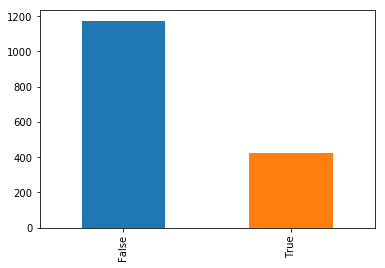

In [178]:
train['First Payment Default'].value_counts().plot(kind='bar')

# First Payment Exploration

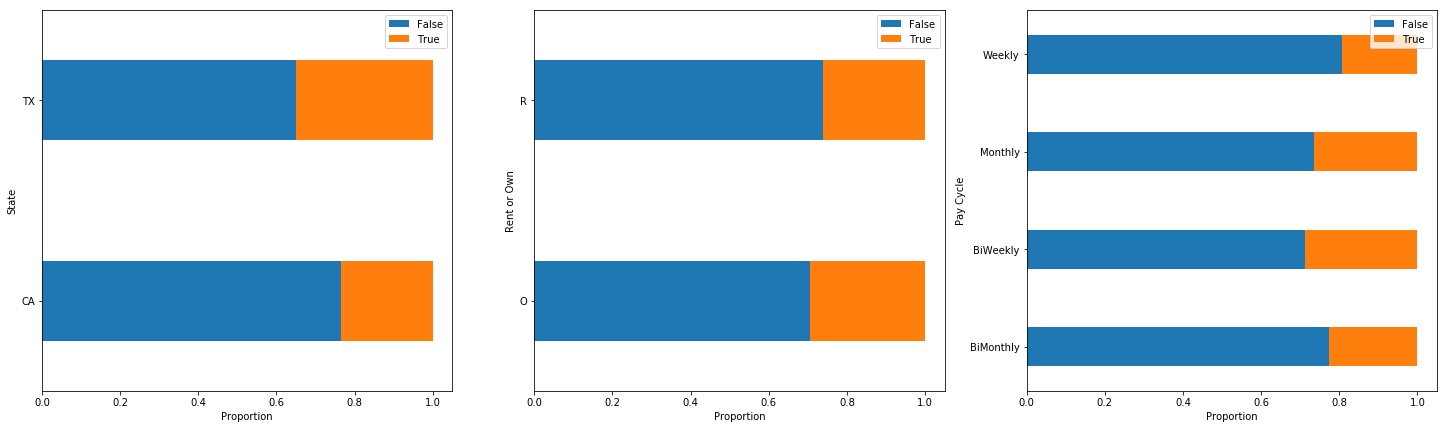

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,7))
df = pd.crosstab(train.State,train['First Payment Default']).apply(lambda r: r/r.sum(), axis=1)
df.plot.barh(stacked=True,width = 0.4,ax=axes[0])
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Proportion')


df = pd.crosstab(train['Rent or Own'],train['First Payment Default']).apply(lambda r: r/r.sum(), axis=1)
df.plot.barh(stacked=True,width = 0.4,ax=axes[1])
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Proportion')

df = pd.crosstab(train['Pay Cycle'],train['First Payment Default']).apply(lambda r: r/r.sum(), axis=1)
df.plot.barh(stacked=True,width = 0.4,ax=axes[2])
axes[2].legend(loc='upper right')
axes[2].set_xlabel('Proportion')

For State we can see that in Texas there is less people with First Payment Default as False than in California.  
For Rent or Own Graph there is almost same proportion of true and false, hence it donot matter weather person is living in rent or owning.  
For Pay Cycle we can see that if person has pay cycle monthly BiWeekly then there is least chance that his First Payment Default is False.

# Monthly Net Income vs First Payment Default

## Data Cleaning

In [180]:
train['Monthly Net Income'] = train['Monthly Net Income'].str.replace(',', '')
train['Monthly Net Income'] = train['Monthly Net Income'].str.replace('$', '')
train['Monthly Net Income'] = train['Monthly Net Income'].astype(str).apply(lambda x: x.strip()).astype(float)

train['Paycheck Net Income'] = train['Paycheck Net Income'].str.replace(',', '')
train['Paycheck Net Income'] = train['Paycheck Net Income'].str.replace('$', '')
train['Paycheck Net Income'] = train['Paycheck Net Income'].astype(str).apply(lambda x: x.strip()).astype(float)

train['Loan Amount'] = train['Loan Amount'].str.replace(',', '')
train['Loan Amount'] = train['Loan Amount'].str.replace('$', '')
train['Loan Amount'] = train['Loan Amount'].astype(str).apply(lambda x: x.strip()).astype(float)

train.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,436.0,2018-03-28T17:27:35Z,CA,2000.0,2000.0,R,12.0,6.0,Monthly,300.00,3/28/2018,4/11/2018,False
1,615.0,2018-03-23T13:19:32Z,TX,3500.0,3500.0,R,60.0,60.0,Monthly,641.91,3/23/2018,4/6/2018,False
2,1251.0,2018-02-28T12:04:56Z,CA,3000.0,3000.0,R,0.0,6.0,Monthly,117.65,2/28/2018,3/30/2018,True
3,440.0,2018-03-28T15:47:59Z,CA,1500.0,1500.0,R,12.0,6.0,Monthly,117.65,3/28/2018,4/28/2018,False
4,1692.0,2018-02-13T04:36:00Z,CA,2392.0,598.0,R,130.0,36.0,Weekly,300.00,2/13/2018,2/23/2018,False


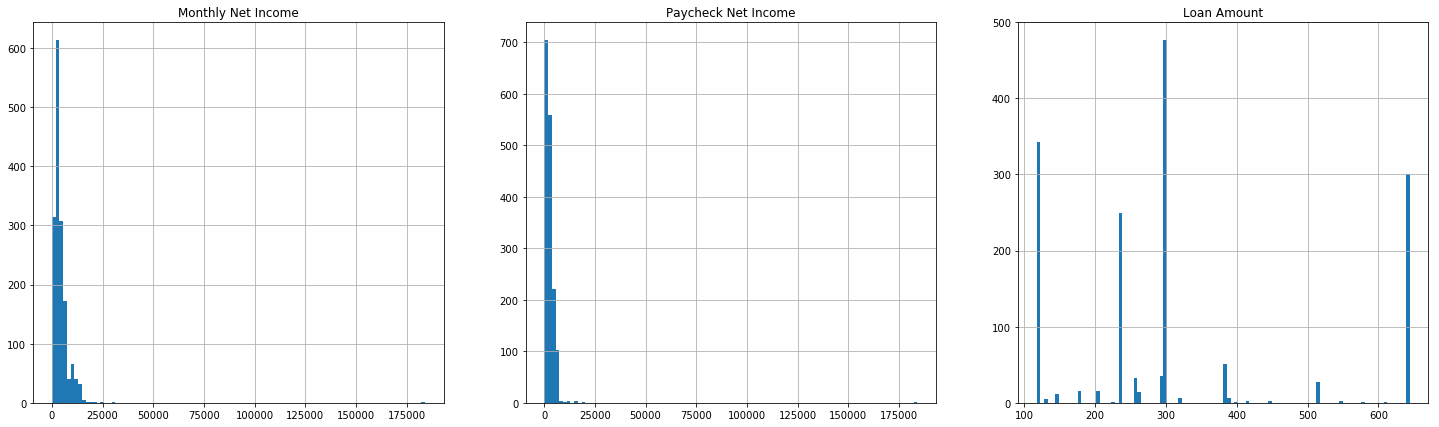

In [181]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,7))
train['Monthly Net Income'].dropna().hist(bins = 100,ax=axes[0])
axes[0].set_title('Monthly Net Income')
train['Paycheck Net Income'].dropna().hist(bins = 100,ax=axes[1])
axes[1].set_title('Paycheck Net Income')
train['Loan Amount'].dropna().hist(bins = 100,ax=axes[2])
axes[2].set_title('Loan Amount')

We can see that there are lot of outliers in each of the graphs. So, we need to remove the outliers since they represent Outlier data which will cause problem when doing prediction.

In [182]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [183]:
# Remove Outliers
train = remove_outlier(train,'Monthly Net Income')
train = remove_outlier(train,'Paycheck Net Income')
train = remove_outlier(train,'Loan Amount')

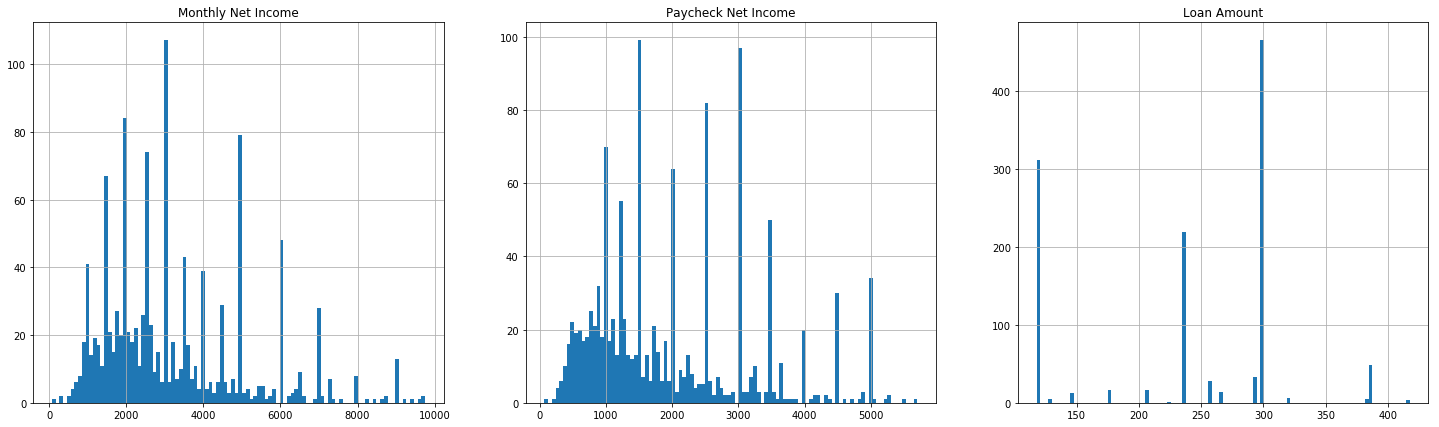

In [184]:
# Now again seeing plots without outliers
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,7))
train['Monthly Net Income'].dropna().hist(bins = 100,ax=axes[0])
axes[0].set_title('Monthly Net Income')
train['Paycheck Net Income'].dropna().hist(bins = 100,ax=axes[1])
axes[1].set_title('Paycheck Net Income')
train['Loan Amount'].dropna().hist(bins = 100,ax=axes[2])
axes[2].set_title('Loan Amount')

Now this data is very clean, hence we can proceed to work with our predictions.

In [185]:
train.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,436.0,2018-03-28T17:27:35Z,CA,2000.0,2000.0,R,12.0,6.0,Monthly,300.00,3/28/2018,4/11/2018,False
2,1251.0,2018-02-28T12:04:56Z,CA,3000.0,3000.0,R,0.0,6.0,Monthly,117.65,2/28/2018,3/30/2018,True
3,440.0,2018-03-28T15:47:59Z,CA,1500.0,1500.0,R,12.0,6.0,Monthly,117.65,3/28/2018,4/28/2018,False
4,1692.0,2018-02-13T04:36:00Z,CA,2392.0,598.0,R,130.0,36.0,Weekly,300.00,2/13/2018,2/23/2018,False
5,804.0,2018-03-17T11:17:38Z,TX,5000.0,2500.0,R,12.0,12.0,BiWeekly,385.06,3/19/2018,3/30/2018,False


We can see there are columns like setID which are of no use to us because they donot help in prediction.  
We can also see that there is date of funding and loan due date, which are important, but it will take a considerable amount of time to get information from the dates, hence to apply our first model, we ignore those column.

In [186]:
train = train.drop(['SetID','Time of Application','Loan Funded Date','Loan Due Date'],axis = 1)
train.head()

,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,First Payment Default
0,CA,2000.0,2000.0,R,12.0,6.0,Monthly,300.00,False
2,CA,3000.0,3000.0,R,0.0,6.0,Monthly,117.65,True
3,CA,1500.0,1500.0,R,12.0,6.0,Monthly,117.65,False
4,CA,2392.0,598.0,R,130.0,36.0,Weekly,300.00,False
5,TX,5000.0,2500.0,R,12.0,12.0,BiWeekly,385.06,False


Converting State, Pay Cycle and other categorical columns into format so that Sklearn can read it. That is we will be creating columns for each value of State and Pay Cycle and its value will be based on if a row contains that value or not.

In [187]:
train = pd.concat([train.drop('State', axis=1), pd.get_dummies(train.State)], axis=1)
train = pd.concat([train.drop('Rent or Own', axis=1), pd.get_dummies(train['Rent or Own'])], axis=1)
train = pd.concat([train.drop('Pay Cycle', axis=1), pd.get_dummies(train['Pay Cycle'])], axis=1)
train.head()

,Monthly Net Income,Paycheck Net Income,Months at Residence,Bank Account Months,Loan Amount,First Payment Default,CA,TX,O,R,BiMonthly,BiWeekly,Monthly,Weekly
0,2000.0,2000.0,12.0,6.0,300.00,False,1,0,0,1,0,0,1,0
2,3000.0,3000.0,0.0,6.0,117.65,True,1,0,0,1,0,0,1,0
3,1500.0,1500.0,12.0,6.0,117.65,False,1,0,0,1,0,0,1,0
4,2392.0,598.0,130.0,36.0,300.00,False,1,0,0,1,0,0,0,1
5,5000.0,2500.0,12.0,12.0,385.06,False,0,1,0,1,0,1,0,0


One last thing we need to do before we proceed to prediction. It is that we need to fill null values in dataset if any. SO, let us check null values in dataset.

In [188]:
for col in train.columns:
    if np.sum(train[col].isna()):
        print(col,' is null')
    else:
        print(col,' is not null')

Monthly Net Income  is not null
Paycheck Net Income  is not null
Months at Residence  is not null
Bank Account Months  is not null
Loan Amount  is not null
First Payment Default  is not null
CA  is not null
TX  is not null
O  is not null
R  is not null
BiMonthly  is not null
BiWeekly  is not null
Monthly  is not null
Weekly  is not null


Since none of column is null hence we donot need to worry about that issue.

# Testing Dataset

In [189]:
test = pd.read_csv('2018-05-17 - Recruit Sample Data Test.csv')
test.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,1,2018-04-09T23:25:18Z,CA,1894.0,947.0,R,8,30,BiWeekly,300.00,2018-04-10,2018-04-20,NaN
1,4,2018-04-09T20:34:56Z,TX,5000.0,5000.0,O,36,36,Monthly,642.46,2018-04-10,2018-04-27,NaN
2,14,2018-04-09T17:41:37Z,TX,2500.0,2500.0,O,108,6,Monthly,644.24,2018-04-09,2018-05-10,NaN
3,19,2018-04-09T16:33:35Z,CA,2902.0,1451.0,R,48,36,BiWeekly,300.00,2018-04-09,2018-04-20,NaN
4,28,2018-04-09T14:51:15Z,CA,5000.0,5000.0,R,12,12,Monthly,235.30,2018-04-09,2018-04-30,NaN


Doing same things with testing datset as we did with training dataset.

In [190]:
test = test.drop(['SetID','Time of Application','Loan Funded Date','Loan Due Date'],axis = 1)
test.head()

,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,First Payment Default
0,CA,1894.0,947.0,R,8,30,BiWeekly,300.00,NaN
1,TX,5000.0,5000.0,O,36,36,Monthly,642.46,NaN
2,TX,2500.0,2500.0,O,108,6,Monthly,644.24,NaN
3,CA,2902.0,1451.0,R,48,36,BiWeekly,300.00,NaN
4,CA,5000.0,5000.0,R,12,12,Monthly,235.30,NaN


Checking null values.

In [191]:
for col in test.columns:
    if np.sum(test[col].isna()):
        print(col,' is null')
    else:
        print(col,' is not null')

State  is not null
Monthly Net Income  is not null
Paycheck Net Income  is not null
Rent or Own  is not null
Months at Residence  is not null
Bank Account Months  is not null
Pay Cycle  is not null
Loan Amount  is not null
First Payment Default  is null


In [192]:
# Droping Last Column Since we need to predict it.
test = test.drop(['First Payment Default'],axis = 1)
test.head()

,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount
0,CA,1894.0,947.0,R,8,30,BiWeekly,300.00
1,TX,5000.0,5000.0,O,36,36,Monthly,642.46
2,TX,2500.0,2500.0,O,108,6,Monthly,644.24
3,CA,2902.0,1451.0,R,48,36,BiWeekly,300.00
4,CA,5000.0,5000.0,R,12,12,Monthly,235.30


In [193]:
test = pd.concat([test.drop('State', axis=1), pd.get_dummies(test.State)], axis=1)
test = pd.concat([test.drop('Rent or Own', axis=1), pd.get_dummies(test['Rent or Own'])], axis=1)
test = pd.concat([test.drop('Pay Cycle', axis=1), pd.get_dummies(test['Pay Cycle'])], axis=1)
test.head()

,Monthly Net Income,Paycheck Net Income,Months at Residence,Bank Account Months,Loan Amount,CA,TX,O,R,BiMonthly,BiWeekly,Monthly,Weekly
0,1894.0,947.0,8,30,300.00,1,0,0,1,0,1,0,0
1,5000.0,5000.0,36,36,642.46,0,1,1,0,0,0,1,0
2,2500.0,2500.0,108,6,644.24,0,1,1,0,0,0,1,0
3,2902.0,1451.0,48,36,300.00,1,0,0,1,0,1,0,0
4,5000.0,5000.0,12,12,235.30,1,0,0,1,0,0,1,0


# Machine Learning

## SVM

In [203]:
from sklearn.svm import SVC

In [204]:
train['First Payment Default'] = train['First Payment Default'].replace({True: 1, False: 0})

In [205]:
cf = SVC()
X_train = train.drop(['First Payment Default'],axis = 1)
Y_train = train['First Payment Default']
X_test = test
cf.fit(X_train,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [207]:
output = cf.predict(X_test)
output

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [210]:
final_output = []
for val in output:
    if val == 0:
        final_output.append(False)
    else:
        final_output.append(True)

In [211]:
test = pd.read_csv('2018-05-17 - Recruit Sample Data Test.csv')
test.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,1,2018-04-09T23:25:18Z,CA,1894.0,947.0,R,8,30,BiWeekly,300.00,2018-04-10,2018-04-20,NaN
1,4,2018-04-09T20:34:56Z,TX,5000.0,5000.0,O,36,36,Monthly,642.46,2018-04-10,2018-04-27,NaN
2,14,2018-04-09T17:41:37Z,TX,2500.0,2500.0,O,108,6,Monthly,644.24,2018-04-09,2018-05-10,NaN
3,19,2018-04-09T16:33:35Z,CA,2902.0,1451.0,R,48,36,BiWeekly,300.00,2018-04-09,2018-04-20,NaN
4,28,2018-04-09T14:51:15Z,CA,5000.0,5000.0,R,12,12,Monthly,235.30,2018-04-09,2018-04-30,NaN


In [212]:
test['First Payment Default'] = final_output
test.head()

,SetID,Time of Application,State,Monthly Net Income,Paycheck Net Income,Rent or Own,Months at Residence,Bank Account Months,Pay Cycle,Loan Amount,Loan Funded Date,Loan Due Date,First Payment Default
0,1,2018-04-09T23:25:18Z,CA,1894.0,947.0,R,8,30,BiWeekly,300.00,2018-04-10,2018-04-20,False
1,4,2018-04-09T20:34:56Z,TX,5000.0,5000.0,O,36,36,Monthly,642.46,2018-04-10,2018-04-27,False
2,14,2018-04-09T17:41:37Z,TX,2500.0,2500.0,O,108,6,Monthly,644.24,2018-04-09,2018-05-10,False
3,19,2018-04-09T16:33:35Z,CA,2902.0,1451.0,R,48,36,BiWeekly,300.00,2018-04-09,2018-04-20,False
4,28,2018-04-09T14:51:15Z,CA,5000.0,5000.0,R,12,12,Monthly,235.30,2018-04-09,2018-04-30,False


In [214]:
test.to_csv('output_file.csv')